# Question 1

## (a)

In [31]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("Admission_Predict.csv")
features = df[["GRE Score", "CGPA", "LOR", "SOP"]]
values = features.values
scaler = StandardScaler()
normalized_features = scaler.fit_transform(values)
print(normalized_features)

[[ 1.81923762  1.77680627  1.09894429  1.13735981]
 [ 0.66714832  0.48585943  1.09894429  0.63231549]
 [-0.0418297  -0.95404281  0.01730621 -0.37777315]
 ...
 [ 1.19888185  1.62785086  1.63976333  1.13735981]
 [-0.39631872 -0.24236699  1.63976333  0.63231549]
 [ 0.93301508  0.76721964  1.09894429  1.13735981]]


## (b)

**If you want, you can read the following material to help you with the code!**

Let's denote $a$ as the output of our simple perceptron model.

$$ \mathbf{a} = \sigma(\mathbf{z}) = \sigma(\mathbf{Xw+b}) $$

where $X\in \mathbb{R}^{N_{bz}\times N_f}$ is the input data, $N_{bz}$ is the batch size (i.e. number of samples in one calculation) and $N_f$ is the dimension of input features. $\mathbf{w}\in \mathbb{R}^{N_f\times N_o}$ is the weights matrix and $\mathbf{b}\in \mathbb{R}^{N_o}$ is the biases. $N_o$ is the dimension of outputs. $\sigma$ is the activation function.

The loss function is defined as half of the mean squared error (MSE) bewteen predicted values $\mathbf{a}$ and the ground truth $\mathbf{O}$:

$$ C = \frac{1}{2}\mathrm{MSE}(\mathbf{a, O}) = \frac{1}{2N_{bz}N_o}\sum_{m}^{N_{bz}}\sum_{i}^{N_o}(a_{mi}-O_{mi})^2$$

Using the chain rule to calculate the gradient of weights and biases. First define

$$ \boldsymbol{\delta} = \frac{\partial C}{\partial \mathbf{z}} = \frac{\partial C}{\partial \mathbf{a}}\odot \sigma'(z) = \frac{1}{N_{bz}N_o}(\mathbf{a}-\mathbf{O})\odot\sigma'(\mathbf{z})$$

where $\odot$ is elementwise product.

$$ \frac{\partial C}{\partial \mathbf{w}} =  \mathbf{X}^T\frac{\partial C}{\partial \mathbf{z}} = \mathbf{X}^T\boldsymbol{\delta}$$

$$ \frac{\partial C}{\partial \mathbf{b}} =  \sum_{m}^{N_{bz}}\boldsymbol{\delta}_m$$

where $\boldsymbol{\delta}_m$ is the $m$-th row of matrix $\boldsymbol{\delta}$.

In [32]:
class SimplePerceptron():
    """
    Implementation of simple perceptron regressor
    """
    def __init__(
        self, 
        input_dim, 
        output_dim, 
        learning_rate=0.0001,
        activation=lambda x: x,
        activation_grad=lambda x: 1
    ):
        """
        Initialize a simple perceptron regressor
        
        Parameters
        ----------
        input_dim: int
            Input dimension
        output_dim: int
            Output dimension
        learning_rate: float
            Learning Rate
        activation: Callable
            Activation function
        activation_grad: Callable
            Activation function's first derivative
        """
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.activation = activation
        self.activation_grad = activation_grad
        self.lr = learning_rate
        self.weights = np.random.uniform(0,0.05, size = (input_dim, output_dim))
        self.biases = np.random.uniform(0,0.05, size = (output_dim, 1))

    def predict(self, X):
        """
        Get predicted values of given input
        
        Parameters
        ----------
        X: numpy.ndarray
            Input samples, shape (n_samples, input_dim)
        
        Returns
        -------
        y: numpy.ndarray
            Output, shape (n_samples, output_dim)
        """
        # Convert rank-1 array to rank-2
        if len(X.shape) == 1:
            X = X.reshape((-1, 1))
        
        # Check that the dimension of accepted input data is the same as expected
        dim = X.shape[1]
        if dim != self.input_dim:
            raise Exception(f"Expected input size {self.input_dim}, accepted {dim}")
        
        self.z = np.dot(X, self.weights) + self.biases 
        self.a = self.activation(self.z) 
        return self.a
    
    def fit(self, X, y):
        """
        Fit the model by doing an steepest descent step
        
        Parameters
        ----------
        X: numpy.ndarray
            Input samples, shape (n_samples, input_dim)
        y: numpy.ndarray
            Labels, shape (n_samples, output_dim)
        """        
        self.predict(X)
        
        errors = (self.a - y) * self.activation_grad(self.z) / y.size   #shape (n_samples, output_dim) 
        weights_grad = np.dot(X.T, errors)                              #shape (input_dim, ouput_dim)
        bias_grad = np.sum(errors, axis=0)                              #shape (output_dim,)

        # Update weights and biases from the gradient
        # just do a simple gradient descent
        self.weights -= self.lr * weights_grad
        self.biases -= self.lr * bias_grad
        
    def train_one_epoch(self, X, y, batch_size=32):
        """
        Train the model for one epoch
        
        Parameters
        ----------
        X: numpy.ndarray
            Input samples, shape (n_samples, input_dim)
        y: numpy.ndarray
            Labels, shape (n_samples, output_dim)
        batch_size: int
            Batch size
        """
        if len(X.shape) == 1:
            X = X.reshape((-1, 1))
        if len(y.shape) == 1:
            y = y.reshape((-1, 1))
            
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        for i in range(0, X.shape[0], batch_size):
            batch = indices[i: i+batch_size]
            self.fit(X[batch], y[batch])

    def evaluate(self, X, y):
        """
        Get the loss function with given data
        
        Parameters
        ----------
        X: numpy.ndarray
            Input samples, shape (n_samples, input_dim)
        y: numpy.ndarray
            Labels, shape (n_samples, output_dim)
        
        Returns
        -------
        L: float
            Loss function value.
        """
        # Transform the single-sample data into 2-dimensional, for the convenience of matrix multiplication
        if len(X.shape) == 1:
            X = X.reshape((-1, 1))
        if len(y.shape) == 1:
            y = y.reshape((-1, 1))
            
        y_pred = self.predict(X)
        # mean squared error
        return np.mean((y_pred - y) ** 2)
    
    def get_weights(self):
        """
        Get weights and biases
        """
        return self.weights.copy(), self.biases.copy()
    
    def set_weights(self, weights, biases):
        """
        Set weights and biases
        """
        self.weights = weights
        self.biases = biases
        
    def prediction_accuracy(self, X, y):
        y_pred = self.predict(X)
        # print(y_pred)
        # print(y)
        return np.mean(y_pred == y)
        

## (c)

Here, we will do the following things:

+ Split the data to $k$-folds, use the $k-1$ folds for training and the other fold for testing
+ In each fold, further split the training data ($k-1$ folds of the whole dataset) by 80\%/20\%. Use the 80\% to train the model in certain epochs and use the 20\% as a validation set to determine the best model during training.
+ For each fold, plot the validation loss against training
+ For each fold, report the mean squared error of the total training set (the $k-1$ fold data) and the test set (the other fold data)  

In [33]:
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt


def KFoldCrossValidation(
    k, X, y, epochs, draw_curve=True, learning_rate=0.0001, 
    activation=lambda x: x, activation_grad=lambda x: 1,
    verbose=True
):
    """
    K-Fold Validation
    
    Parameters
    ---------
    k: int
        The number of fold in validation
    X: numpy.ndarray
        Input samples, shape (n_samples, input_dim)
    y: numpy.ndarray
        Labels, shape (n_samples, output_dim)
    epochs: int
        Number of training epochs
    draw_curve: bool
        Whether to draw the validation loss against training steps
    learning_rate: float
        Learning rate
    activation: Callable
        Activation function
    activation_grad: Callable
        Gradient of activate function
    verbose: bool
        Whether to print information
    
    Returns
    ------
    model: list
        List of k models
    """
    # Reshape the X,y if they are rank-1
    if len(X.shape) == 1:
        X = X.reshape((-1, 1))
    if len(y.shape) == 1:
        y = y.reshape((-1, 1))
    input_dim = X.shape[1]
    output_dim = y.shape[1]
    
    # do a 5-fold validation
    kf = KFold(n_splits=k, shuffle=True)
    
    if draw_curve:
        n_row, n_col = int(np.ceil(k / 3)), 3
        fig, axes = plt.subplots(n_row, n_col, figsize=(5 * n_col, 5 * n_row), constrained_layout=True)
        axes = axes.flatten()
    
    models = []
    train_err_list, test_err_list = [], []
    for i, (train_selector, val_selector) in enumerate(kf.split(X)):
        # Decide training examples and testing examples for this fold
        X_train, X_test = X[train_selector], X[val_selector]
        y_train, y_test = y[train_selector], y[val_selector]
        
        # define you models here
        model = SimplePerceptron(input_dim, output_dim, learning_rate, activation, activation_grad)
        
        # futher split the X_train by 80%/20%
        # use train_test_split function in sklearn
        X_train_in, X_val, y_train_in, y_val = train_test_split(X, y, test_size=0.2)
        
        lowest_val_err = np.inf
        val_err_list = []
        for _ in range(epochs):
            # Train model on a number of epochs, and test performance in the validation set
            model.train_one_epoch(X_train_in, y_train_in)
            val_err = model.evaluate(X_val, y_val)
            val_err_list.append(val_err)
            if val_err < lowest_val_err:
                lowest_val_err = val_err
                weights, biases = model.get_weights()

        # The final number of epochs is when the minimum error in validation set occurs    
        if verbose:
            print("Number of epochs with lowest validation:", np.argmin(val_err_list))
        model.set_weights(weights, biases)
        models.append(model)

        # Report MSE on X_train and X_test
        train_err = model.evaluate(X_train, y_train)
        train_err_list.append(train_err)
        test_err = model.evaluate(X_test, y_test)
        test_err_list.append(test_err)
        
        if draw_curve:
            axes[i].plot(np.arange(epochs), np.log10(val_err_list), label='Validation loss')
            axes[i].set_xlabel('Epochs')
            axes[i].set_ylabel('Log Loss')
            axes[i].legend()
            axes[i].set_title(f"Epoch {i}")
    
    if verbose:      
        print("Final results:")
        print(f"Training error: {np.mean(train_err_list)}+/-{np.std(train_err_list)}")
        print(f"Testing error: {np.mean(test_err_list)}+/-{np.std(test_err_list)}")
    
    return models

Number of epochs with lowest validation: 49
Number of epochs with lowest validation: 49
Number of epochs with lowest validation: 49
Number of epochs with lowest validation: 49
Number of epochs with lowest validation: 49
Final results:
Training error: 0.43558220396141845+/-0.008090148660138166
Testing error: 0.43636993242527494+/-0.015558650449522194


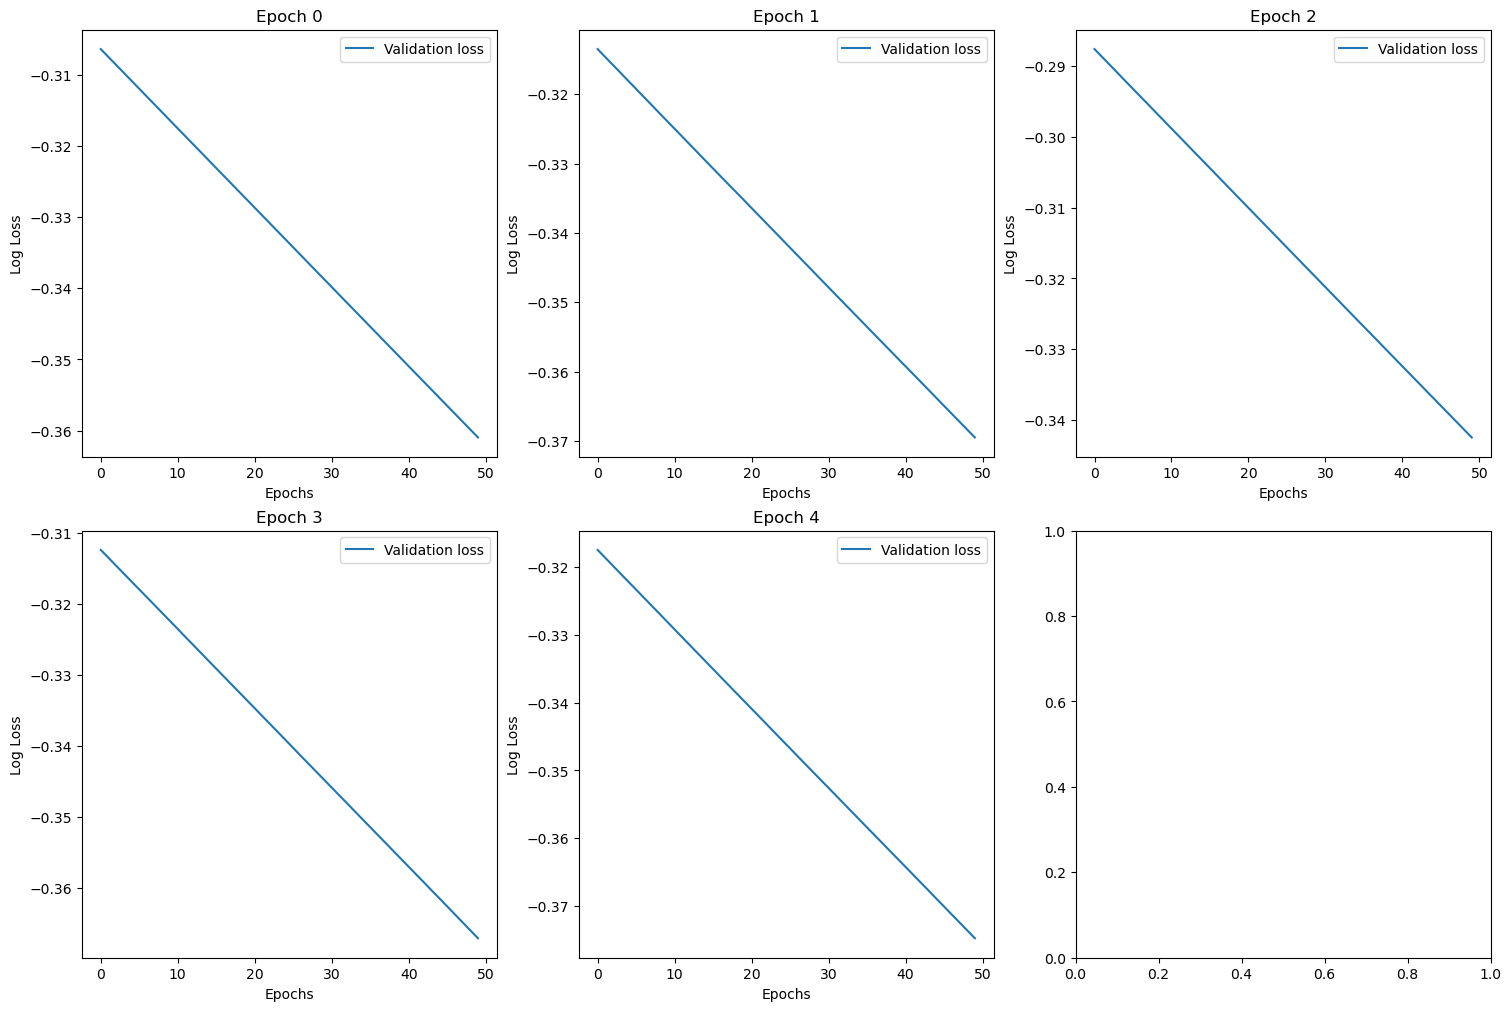

In [34]:
KFoldCrossValidation(5, normalized_features, df["Chance of Admit"].values, 50)

### Are the features good indicators for getting into graduate school? 
Yes, the features are good indicators of getting into graduate school. We can see this becuase the training and test error are both low and very similar, meaning that there is good generalization to new data.

In [35]:
# remove the GRE score feature
features_no_GRE = df[["CGPA", "LOR", "SOP"]]
values_no_GRE = features.values
scaler = StandardScaler()
normalized_features_no_GRE = scaler.fit_transform(values_no_GRE)

Number of epochs with lowest validation: 49
Number of epochs with lowest validation: 49
Number of epochs with lowest validation: 49
Number of epochs with lowest validation: 49
Number of epochs with lowest validation: 49
Final results:
Training error: 0.44077786775591177+/-0.008773000080977424
Testing error: 0.43889349542794526+/-0.00713641040144757


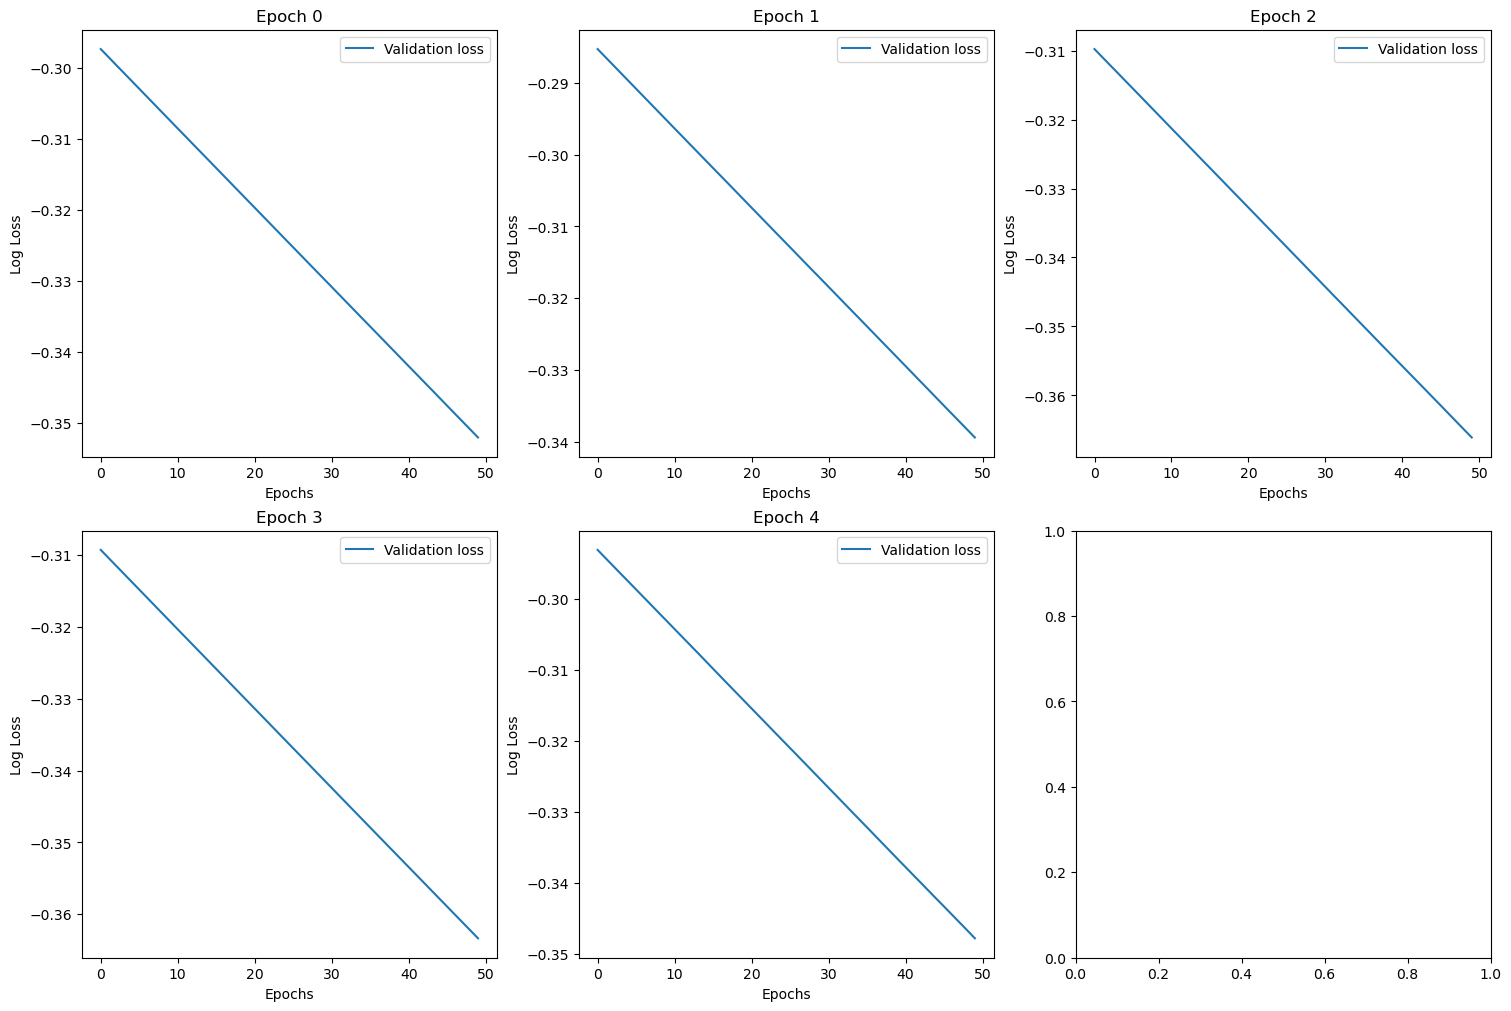

In [36]:
KFoldCrossValidation(5, normalized_features_no_GRE, df["Chance of Admit"].values, 50)

### Are GRE scores important?
Yes, the GRE scores are an important feature. We can see that when we removed the GRE feature, the training error increased slightly. This means that including the GRE scores helps inmprove the accuracy of training. 

# Question 2

## (a)

*Hint: Think about what activation function in the SimplePerceptron model should be used to perform a logistic regression?*

One-dimension logistic regression expression:

$$ y = \frac{1}{1+e^{-(ax+b)}} $$

In [37]:
df_titanic = pd.read_csv("titanic.csv")
df_titanic = df_titanic.dropna() # drop rows where values are missing
df_titanic

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S
...,...,...,...,...,...,...,...,...,...,...,...,...
871,872,1,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1,1,11751,52.5542,D35,S
872,873,0,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0000,B51 B53 B55,S
879,880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C50,C
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S


In [38]:
from sklearn.preprocessing import OneHotEncoder

categorical_features = df_titanic[["Pclass", "Sex", "Embarked", "Survived"]]

encoder = OneHotEncoder()

X_cate = categorical_features.values
survived = df_titanic["Survived"].values
X_onehot_cate = encoder.fit_transform(X_cate).toarray()

print(X_onehot_cate.shape)
X_onehot_cate

(183, 10)


array([[1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 1.],
       [1., 0., 0., ..., 1., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.]])

## (b)

In [39]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_grad(z):
    return sigmoid(z)*(1 - sigmoid(z))

Number of epochs with lowest validation: 49
Number of epochs with lowest validation: 49
Number of epochs with lowest validation: 49
Number of epochs with lowest validation: 49
Number of epochs with lowest validation: 49
Final results:
Training error: 0.24070662788765898+/-0.002191928902887579
Testing error: 0.24045549520426937+/-0.003586239947303187


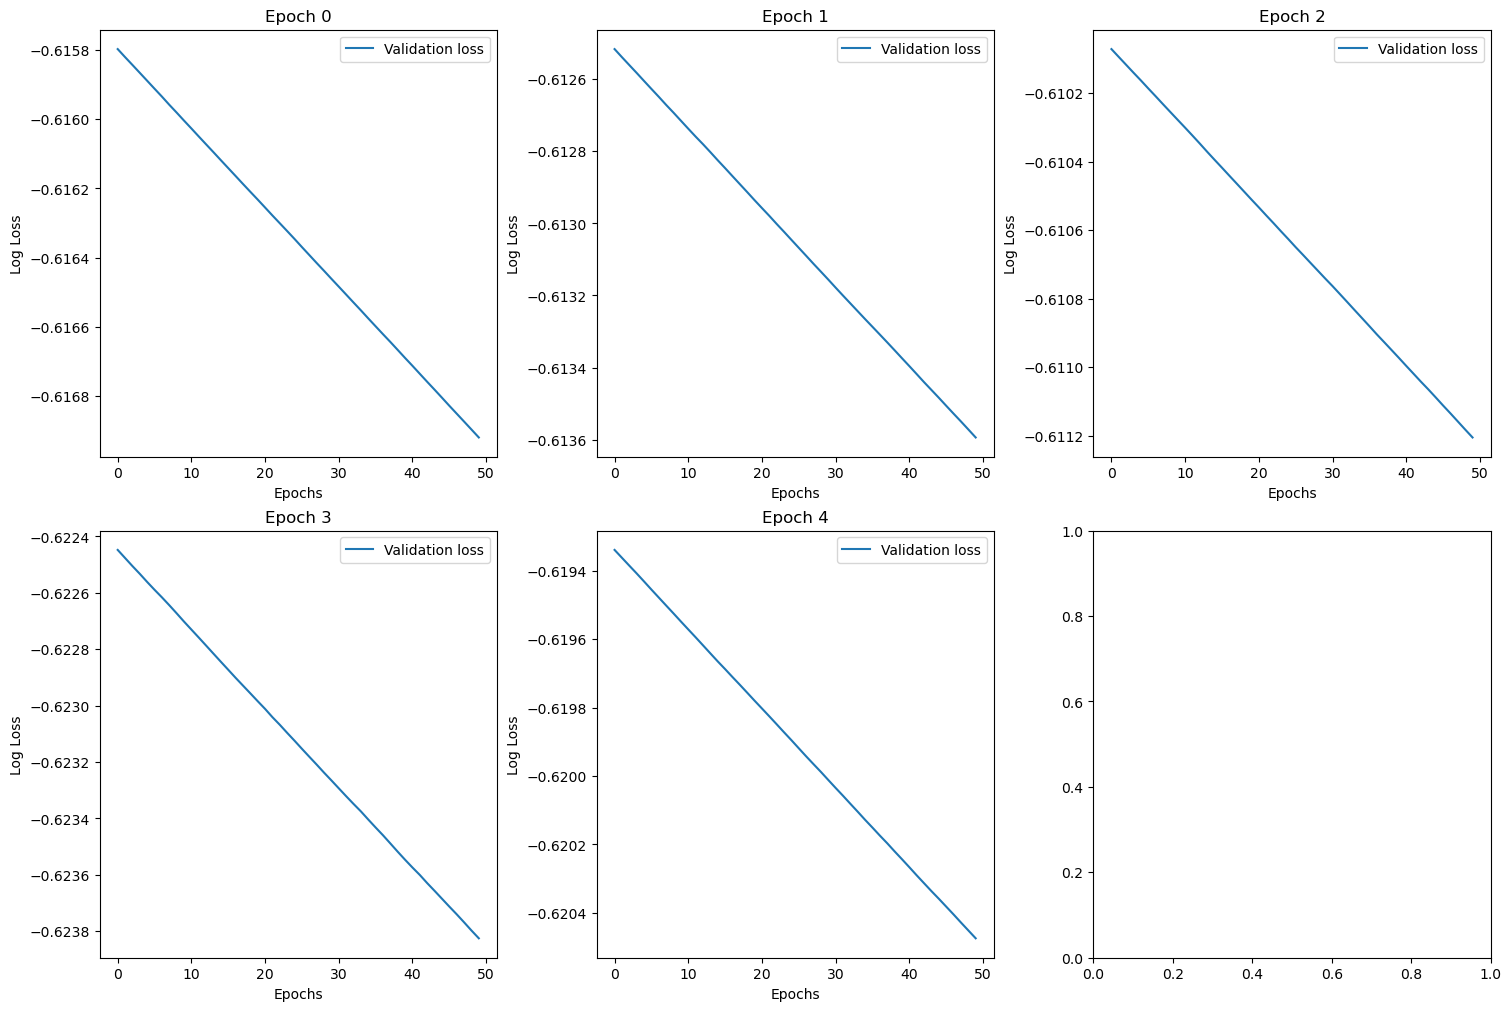

In [40]:
model = KFoldCrossValidation(5, X_onehot_cate, 
                             survived, 50, 
                             learning_rate=0.0001, 
                             activation=sigmoid, 
                             activation_grad = sigmoid_grad)
model

In [41]:
# Count the number predicted to survive
predictions = []
for m in model:
    fold_predictions = m.predict(X_onehot_cate)
    predictions.append(fold_predictions)

predictions = np.mean(predictions, axis=0) >= 0.5
num_survived = np.sum(predictions)

print("Number predicted to survive:", num_survived)

Number predicted to survive: 183


In [42]:
# Count actual number who survived
counts = df_titanic['Survived'].value_counts()

# If you want to count the occurrences of a specific value, let's say 'value_to_count'
count_of_survived = counts.get(1, 0)  # Returns 0 if 'value_to_count' is not found

print("Number who actually survived:", count_of_survived)

Number who actually survived: 123


### Can we predict who will survive? 
The model generated from Kfold variation provides us with enough information to predict who will survive. We can find the predicted survival probability and then count those with a prediction of over 0.5 to have survived. From this method, the model predicts 183 passengers will survive, whereas in reality, only 123 survived. 

# Question 3

## (a)

**Note**: `KFoldCrossValidation` returns a model list, just pick any one of them (for example, the first) for prediction on test dataset.

In [43]:
def generate_X(number, boundary):
    x = (np.random.random(number) * 2 - 1) * boundary
    return x
    
def generate_data(number, stochasticity=0.2):
    x = generate_X(number, 10)
    ratio = generate_X(number, stochasticity) + 1
    y = 3 * np.sin(x) * ratio + 5
    return x, y

In [44]:
def show_correlation(y_pred, y_true):
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    r = [
        np.min([np.min(y_pred), np.min(y_true)]), 
        np.max([np.max(y_pred), np.max(y_true)])
    ]
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    plt.scatter(y_pred, y_true, s=5)
    ax.plot(r, r, color='red')
    ax.set_xlabel("Predictions")
    ax.set_ylabel("Ground truth")
    corr = np.corrcoef([y_pred, y_true])[1, 0]
    print("Correlation coefficient:", corr)

def show_plot(x, y_true, y_pred=None):
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    ax.scatter(x, y_true, s=0.5, label='Ground Truth')
    if y_pred is not None:
        ax.scatter(x, y_pred, s=0.5, label="Predicted")
    ax.legend()

### Generate data

Number of epochs with lowest validation: 49
Number of epochs with lowest validation: 49
Number of epochs with lowest validation: 49
Number of epochs with lowest validation: 49
Number of epochs with lowest validation: 49
Final results:
Training error: 11.295613101514494+/-0.11992274462090642
Testing error: 11.294008730825821+/-0.324205004080506
Correlation coefficient: 0.20337942303658596


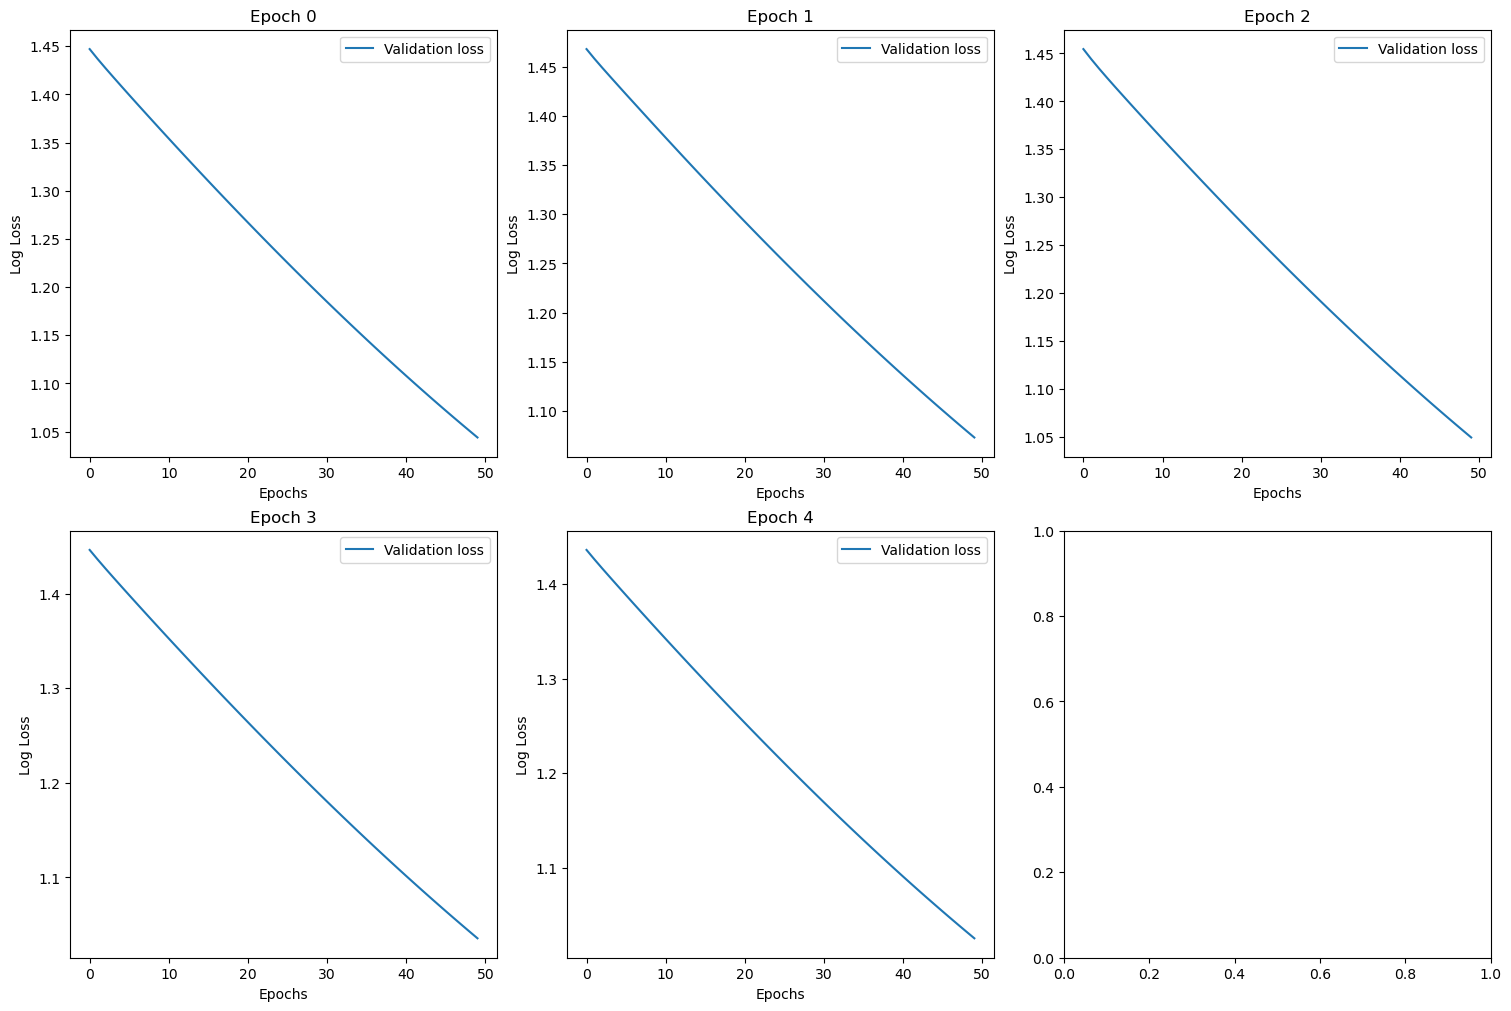

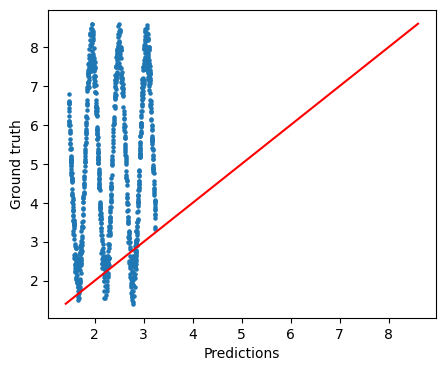

In [45]:
X_train, y_train = generate_data(5000)
models = KFoldCrossValidation(5, X_train, y_train, 50)

X_test, y_test = generate_data(1000)

# Evaluate model performance
predictions = np.mean([model.predict(X_test) for model in models], axis=0)
show_correlation(predictions, y_test)

### How well is the prediction?

Since the correlation coefficient between the predictions and the actual y data is low (~0.203), this means the predictions aren't very good.

## (b)

In [68]:
from sklearn.neural_network import MLPRegressor

def mse(y_pred, y_true):
    return np.mean((y_pred - y_true) ** 2)
    
def KFoldCrossValidationMLP(
    k, X, y, epochs, 
    learning_rate=0.01, 
    activation='tanh',
    hidden_layers=(8,),
    verbose=True
):
    """
    K-Fold Validation for MLPRegressor
    
    Parameters
    ---------
    k: int
        The number of fold in validation
    X: numpy.ndarray
        Input samples, shape (n_samples, input_dim)
    y: numpy.ndarray
        Labels, shape (n_samples, output_dim)
    epochs: int
        Number of training epochs
    kwargs: keyword arguments
        Arguments to init a SimplePerceptron model. i.e. learning_rate, activation, activation_grad
    
    Returns
    ------
    model: SimplePerceptron
        The best model
    """
    # MLPRegressor takes 2D array for features
    # and 1D array for labels if the dimension of output is 1
    if len(X.shape) == 1:
        X = X.reshape(-1, 1) 

    # do a 5-fold validation
    kf = KFold(n_splits=k, shuffle=True)
    
    models = []
    train_err_list, test_err_list = [], []
    for i, (train_selector, val_selector) in enumerate(kf.split(np.arange(X.shape[0]))):
        # Decide training examples and testing examples for this fold
        X_train, X_test = X[train_selector], X[val_selector]
        y_train, y_test = y[train_selector], y[val_selector]
        
        model = MLPRegressor(
            max_iter=epochs,
            activation=activation, 
            learning_rate_init=learning_rate,
            hidden_layer_sizes=hidden_layers,
            early_stopping=True, validation_fraction=0.2, learning_rate='constant', 
        )
        model.fit(X_train, y_train)
        models.append(model)

        # Report MSE on X_train and X_test
        y_train_pred = model.predict(X_train)
        train_err = mse(y_train_pred, y_train)
        train_err_list.append(train_err)
        
        y_test_pred = model.predict(X_test)
        test_err = mse(y_test_pred, y_test)
        test_err_list.append(test_err)
        if verbose:
            print(f"Train error: {train_err}, Test error: {test_err}")
        
    
    if verbose:      
        print("Final results:")
        print(f"Training error: {np.mean(train_err_list)}+/-{np.std(train_err_list)}")
        print(f"Testing error: {np.mean(test_err_list)}+/-{np.std(test_err_list)}")
    
    return models[np.argmin(test_err_list)]

In [71]:
model = KFoldCrossValidationMLP(5, X_test, y_test, 7500, hidden_layers=(1,))

Train error: 3.9953453059003654, Test error: 4.157374084455151
Train error: 4.076738186634198, Test error: 3.888049833791682
Train error: 4.08631862099766, Test error: 4.50109066818253
Train error: 4.066905458180471, Test error: 4.005743771233992
Train error: 4.116433577595481, Test error: 3.9720623671380597
Final results:
Training error: 4.068348229861635+/-0.04009248182871925
Testing error: 4.104864144960283+/-0.21643583698567223


MLPRegressor(activation='tanh', early_stopping=True, hidden_layer_sizes=(1,),
             learning_rate_init=0.01, max_iter=7500, validation_fraction=0.2)
Correlation coefficient: 0.19615851713236326


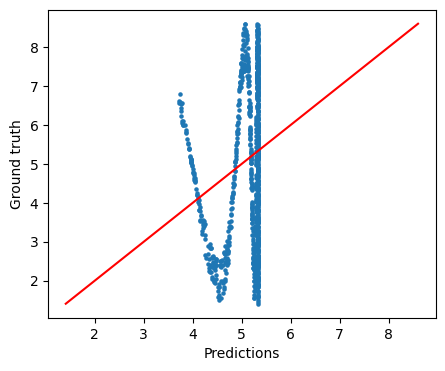

In [72]:
print(model)
y_pred = model.predict(X_test.reshape(-1, 1))
show_correlation(y_pred, y_test)

### Is the result better than a simple perceptron?
No, the result is not much better than the simple perceptron, with a correlation coefficient of 0.196.

## (c)

If we increase the number of hidden layers to 8, the model performs much better than the simple perceptron model. The correlation coefficient is 0.932 meaning that there is a strong positive linear correlation between the predictions and the true values. 

Train error: 0.5943564215766284, Test error: 0.4524562849214399
Train error: 3.8911745822113932, Test error: 3.8519649341190223
Train error: 3.717289387684167, Test error: 3.9026383576329677
Train error: 3.9645161335266277, Test error: 4.1853458166844915
Train error: 4.070166046281564, Test error: 4.13742772382811
Final results:
Training error: 3.247500514256076+/-1.3315465777610291
Testing error: 3.3059666234372065+/-1.4325702700148035
MLPRegressor(activation='tanh', early_stopping=True, hidden_layer_sizes=(8,),
             learning_rate_init=0.01, max_iter=7500, validation_fraction=0.2)
Correlation coefficient: 0.9316910921325227


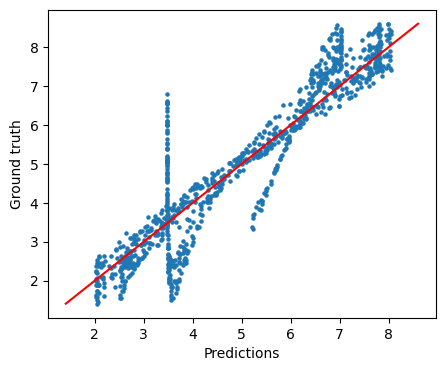

In [73]:
model = KFoldCrossValidationMLP(5, X_test, y_test, 7500, hidden_layers=(8,))
print(model)
y_pred = model.predict(X_test.reshape(-1, 1))
show_correlation(y_pred, y_test)